[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.15 - 0.75 PHz
[ Info: Samples needed: 4496.89, samples: 8192, δt = 222.38 as
[ Info: Requested time window: 1000.0 fs, actual time window: 1821.7 fs
[ Info: Grid: samples 4096 / 8192, ωmax 7.06e+15 / 1.41e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 15.76 eV, 1030.0 nm
[ Info: Using mode-averaged propagation.
[ Info: Found FFTW wisdom at C:\Users\yl9521\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\yl9521\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\yl9521\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\yl9521\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcache_1threads
[ Info: Starting propagation
[ Info: Propagation finished in 0.151 secon

first wedge2.989501762107267e-13mmfirst input energy0.3039999914290754mJafter first chirp mirror0.21594803570853946mJ

[ Info: X+Y polarisation not required.
[ Info: Freq limits 0.07 - 2.31 PHz
[ Info: Samples needed: 6918.29, samples: 8192, δt = 72.27 as
[ Info: Requested time window: 500.0 fs, actual time window: 592.1 fs
[ Info: Grid: samples 4096 / 8192, ωmax 2.17e+16 / 4.35e+16
[ Info: Using PPT ionisation rate.
[ Info: Found cached PPT rate for 15.76 eV, 1030.0 nm
[ Info: Using mode-averaged propagation.


first wedge2.989501762107267e-13mm

[ Info: Found FFTW wisdom at C:\Users\yl9521\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\yl9521\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcache_1threads
[ Info: Found FFTW wisdom at C:\Users\yl9521\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcache_1threads
[ Info: FFTW wisdom saved to C:\Users\yl9521\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcache_1threads
[ Info: Starting propagation


second pass input0.17223871195511933mJdouble pass out energy0.09686850923510279mJsecond wedge50.940877406335815

[ Info: Propagation finished in 3.888 seconds, 1791 steps


mm

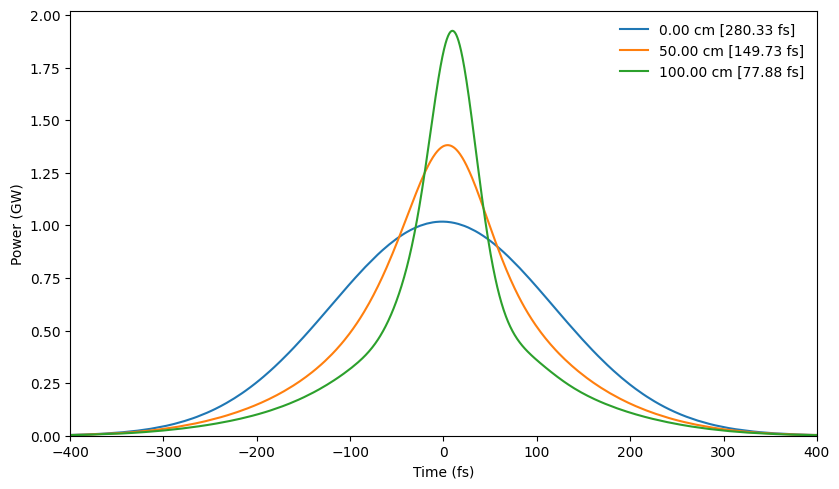

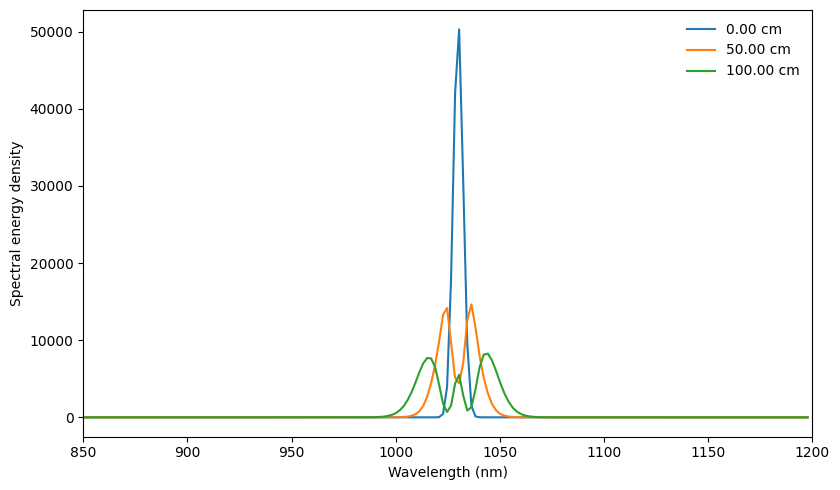

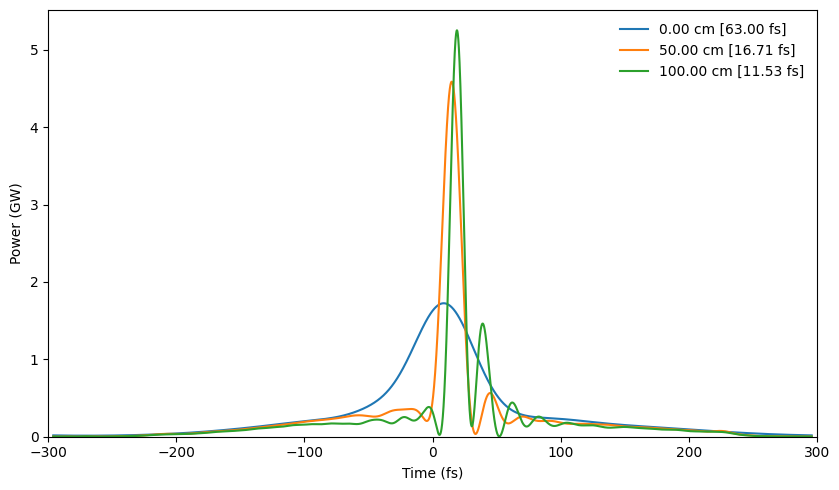

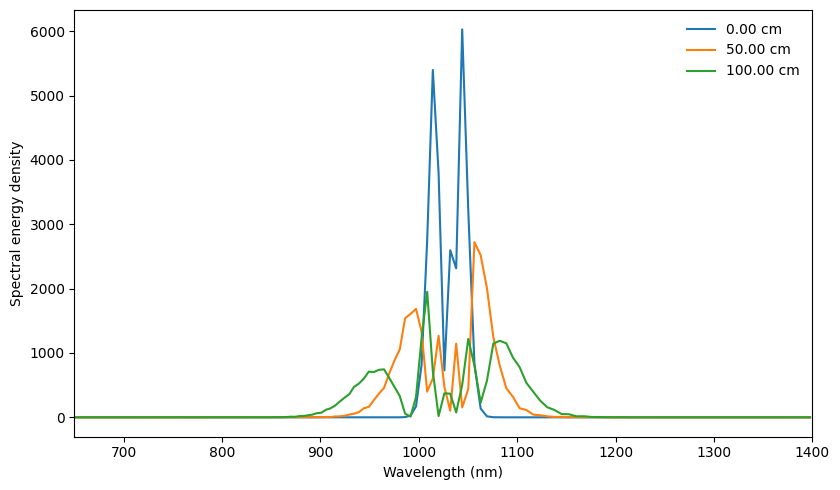

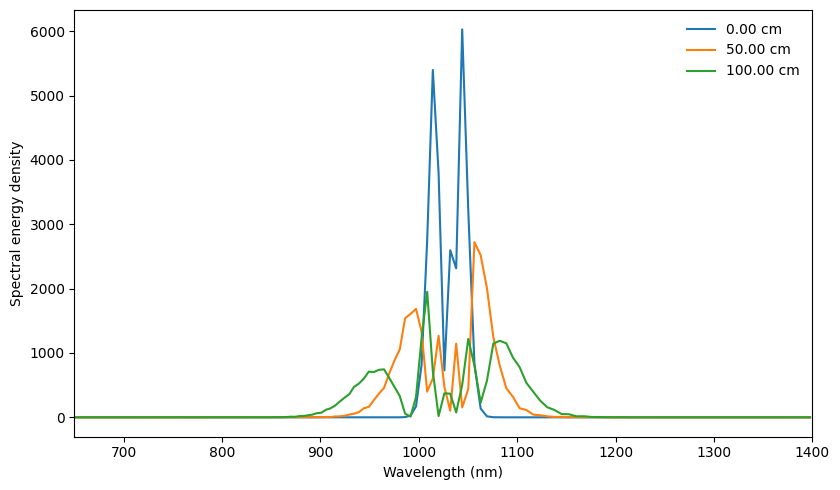

In [121]:
using Luna
import PyPlot: ColorMap, plt, pygui, Figure

#Laser
λ0 = 1030e-9      #wavelength in nm
τfwhm = 280e-15   #pulse duration in s
energy = 0.4e-3*0.8*0.95   #pulse energy in J (introduce 80% coupling efficiency, 95% for TFP_trans)

#Fiber1
gas = :Ar
a_HCF1 = 125e-6 # core radius in m
p_HCF1 = 3.8    # gas pressure in bar
length_HCF1 = 1.0 # fiber length in m

λlims_1 = (400e-9, 2000e-9) # grid wavelength limits
trange_1 = 1e-12 # time grid size

modes = :HE11 # number of modes

#Propagation in the first HCF
#This function is used for plotting
output = prop_capillary(a_HCF1, length_HCF1, gas, p_HCF1; λ0, τfwhm, energy, λlims=λlims_1, trange=trange_1, modes)

##
# propagator function which propagates the field between the 1st to the 2nd HCF, a.k.a. compression stage 1
# this mutates (i.e. rewrites) its input as required for the LunaPulse
function prop!(Eω, grid)
    Fields.prop_mirror!(Eω, grid, :PC1611,8) #chirped mirror bounces
    # optimise compression with silica insertion (i.e. wedges)
    d, Eωopt = Fields.optcomp_material(Eω, grid, :CaF2, λ0, 0, 20e-3) #min_thickness, max_thickness 20mm
    print("first wedge",d*1000,"mm")
    Eω .= Eωopt
end

# non-mutating version (keeps the input value) of prop! as required for plotting
function prop(grid, Eω)
    Eωout = copy(Eω)
    prop!(Eωout, grid)
    Eωout
end

##
# Plot the compressed pulse
Plotting.time_1D(output,[0,0.5,1]; trange=(-400e-15, 400e-15),modes=:sum, propagate=prop)
Plotting.spec_1D(output, [0, 0.5, 1];λrange=(850e-9, 1200e-9),log10=false)
#Plotting.prop_2D(output; modes=:sum)


##
# Parameters for 2nd fiber
#Fiber2
a_HCF2 = 125e-6
p_HCF2 = 3.8
length_HCF2 = 1.0

##
# Luna will consider the reflectivity of the chirp mirrors to calculate the energy
first_input_energy = first(Processing.energy(output))
#print(Processing.energy(output)*1000)
print("first input energy",first_input_energy*1000,"mJ")
energy_HCF2 =  last(Processing.energy(output))*0.9       #(introduce 90% mirror reflection)
print("after first chirp mirror",energy_HCF2*1000,"mJ")


λlims_2 = (130e-9, 4e-6)
trange_2 = 500e-15

#Pulse data after HCF1 and compression stage 1
pulse = Pulses.LunaPulse(output; energy=energy_HCF2*0.8, propagator=prop!) #introduce 80% coupling efficiency into 2nd HCF

#2nd HCF
output2 = prop_capillary(a_HCF2, length_HCF2, gas, p_HCF2; λ0, pulses=pulse, modes, λlims=λlims_2, trange=trange_2)

#Final compression stage after 2nd HCF
function propa!(Eω, grid)
    Fields.prop_mirror!(Eω, grid, :PC1611, 8) #chirped mirror bounces
    # optimise compression with silica insertion (i.e. wedges)
    d, Eωopt = Fields.optcomp_material(Eω, grid, :CaF2, λ0, 0, 55e-3) #min_thickness, max_thickness 20mm
    print("second wedge",d*1000,"mm")
    Eω .= Eωopt
end

# non-mutating version of prop! as required for plotting
function propa(grid, Eω)
    Eωout1 = copy(Eω)
    propa!(Eωout1, grid)
    Eωout1
end

print("second pass input",first(Processing.energy(output2))*1000,"mJ")
energy_HCF_out_DP =  last(Processing.energy(output2))*0.9*0.8   #final stage of CM and 80% eff of TFP_ref
print("double pass out energy",energy_HCF_out_DP*1000,"mJ")


Plotting.time_1D(output2,[0,0.5,1]; trange=(-300e-15, 300e-15),FTL=false,modes=:sum, propagate=propa)
Plotting.spec_1D(output2, [0, 0.5, 1]; λrange=(650e-9, 1400e-9),log10=false)



#output1 = prop_capillary(a_HCF1, length_HCF1*2, gas, p_HCF1; λ0, τfwhm, energy, λlims=λlims_1, trange=trange_1,modes)
#energy_HCF_out_single =  last(Processing.energy(output1))*0.9
#print("single 2m out energy",energy_HCF_out_single*1000,"mJ")
#Plotting.time_1D(output1,[0,0.5,1,2]; trange=(-400e-15, 400e-15),modes=:sum, propagate=prop)
#Plotting.spec_1D(output1, [0, 0.5, 1,2];λrange=(850e-9, 1200e-9),log10=false)



